In [3]:
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Optional, Literal
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
load_dotenv()

True

In [26]:
# LangChain setup for intent detection
class IntentClassification(BaseModel):
    intent: Literal["make a reservation", "check reservation", "change reservation", "other"] = Field(
        ..., description="The classified intent of the user's message"
    )


# LangChain setup for intent detection
intent_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a hotel booking system. The user will provide a message, and you must classify their intent into one of the following categories:
1. "make a reservation"
2. "check reservation"
3. "change reservation"
4. "other"

Last asked question: {assistant_question} 
User's reply: {answer}

Classify the intent as one of these four: "make a reservation", "check reservation", "change reservation", or "other".

Observation:
1. if the "Last asked question" is empty, interpret the answer as the first reply of the conversation
""")

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Create a structured output chain for intent detection
intent_chain = intent_prompt | llm.with_structured_output(IntentClassification)


In [5]:
class BookingInfo(BaseModel):
    full_name: Optional[str] = Field(None, description="The full name of the guest")
    check_in_date: Optional[str] = Field(
        None, description="Check-in date for the reservation"
    )
    check_out_date: Optional[str] = Field(
        None, description="Check-out date for the reservation"
    )
    num_guests: Optional[int] = Field(
        None, description="Number of guests for the reservation"
    )
    payment_method: Optional[str] = Field(
        None, description="Payment method used for the reservation"
    )
    breakfast_included: Optional[bool] = Field(
        None, description="Whether breakfast is included"
    )


# LangChain setup for booking information extraction
booking_info_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a hotel booking system. Your task is to extract relevant booking information from the user's message. Extract only the information that is explicitly mentioned in the message.

User's message: {message}

Please extract the following information if present:
1. Full Name (The full name of the guest. Only first name is not enough to fill this information)
2. Check-in Date
3. Check-out Date
4. Number of Guests
5. Payment Method
6. Whether Breakfast is Included

If a piece of information is not mentioned in the message, leave it as None.

Provide the extracted information in a structured format.
""")

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Create a structured output chain for booking information extraction
booking_info_chain = booking_info_prompt | llm.with_structured_output(BookingInfo)


# Example usage
def extract_booking_info(user_message: str):
    result = booking_info_chain.invoke({"message": user_message})
    return result


user_message = "I'd like to book a room for John from July 15 to July 20 for 2 people. We'll pay by credit card and would like breakfast included."
# user_message = "Today is a beautiful day to go to the beach" # testing irrelevant message
extracted_info = extract_booking_info(user_message)
print(extracted_info)


full_name=None check_in_date='July 15' check_out_date='July 20' num_guests=2 payment_method='credit card' breakfast_included=True


In [6]:
# LangChain setup for changing information characteristics
booking_change_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a hotel booking system. Your task is to extract the information the user wants to change in his reservation. Extract only the information that is explicitly mentioned in the message.

User's message: {message}

Current booking information:
Full Name: {full_name}
Check-in Date: {check_in_date}
Check-out Date: {check_out_date}
Number of Guests: {num_guests}
Payment Method: {payment_method}
Breakfast Included: {breakfast_included}

Please detect if the user wants to change one or more messages from the list below:
1. Full Name
2. Check-in Date
3. Check-out Date
4. Number of Guests
5. Payment Method
6. Whether Breakfast is Included

Attention:
1. If the user wants to change the reservation date, carefully evaluate whether it is necessary to change only Check-in date, only the Check-out date, or to change both dates.

Provide the extracted information in a structured format.
""")

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Create a structured output chain for booking information extraction
booking_change_chain = booking_change_prompt | llm.with_structured_output(BookingInfo)


# testing the chain
payload = {
    "message": "I'd like to change the date of my reservation for two weeks from now",
    "full_name": None,
    "check_in_date": "2024-10-12",
    "check_out_date": "2024-11-12",
    "num_guests": None,
    "payment_method": None,
    "breakfast_included": None,
}

# user_message = "Today is a beautiful day to go to the beach" # testing irrelevant message
extracted_info = booking_change_chain.invoke(payload)
print(extracted_info)


full_name=None check_in_date='2024-10-26' check_out_date=None num_guests=None payment_method=None breakfast_included=None


In [7]:
# Langchain setup for response generation
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser

# System prompt
system_template = """
You are a hotel booking assistant. Your primary tasks are:
1. Assist users in making new reservations
2. Help users check existing reservations
3. Politely redirect users if their query is unrelated to reservations

Remember to be friendly, professional, and focused on the user's needs.
"""

# Human message template
human_template = """
Generate an appropriate response based on the user's intent and the current state of the conversation.

Current intent: {intent}

Current booking information:
Full Name: {full_name}
Check-in Date: {check_in_date}
Check-out Date: {check_out_date}
Number of Guests: {num_guests}
Payment Method: {payment_method}
Breakfast Included: {breakfast_included}

Instructions based on intent:

1. If the intent is "other":
   Politely inform the user that you can only assist with making or checking reservations. Say something like: "As a hotel booking assistant, I am only able to answer questions related to making a reservation or checking a reservation. Would you like help with this?"

2. If the intent is "make a reservation":
   Review the booking information provided. For any information that is None or not provided, ask a follow-up question to collect that specific piece of information. Be polite and ask one question at a time. If all information is provided, confirm the details and ask if the user wants to proceed with the booking.
   
Observations:

1. When you generate responses related to dates, ALWAYS ask the user to provide the dates in the format YYYY-MM-DD.
2. When refering to the customer use only their first name. Nonetheless make sure you collect the full customer's name.
3. If the user's full name was already provided (Full Name is not None), do not introduce yourself again.

Generate a response that addresses the user's intent based on these instructions:
"""

# Create the chat prompt template
generate_response_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template(human_template),
])

llm = ChatOpenAI(model="gpt-4o", temperature=0)
response_chain = generate_response_prompt | llm | StrOutputParser()

# testing the chain
current_state = {
    "intent": "make a reservation",
    "user_message": "I want to book a double bed room",
    "full_name": None,
    "check_in_date": None,
    "check_out_date": None,
    "num_guests": None,
    "payment_method": None,
    "breakfast_included": None
}

response_chain.invoke(input=current_state)

"Hello! I'd be happy to help you make a reservation. Could you please provide your full name to get started?"

In [8]:
# create summarization chain:
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# System prompt
system_template = """
You are a hotel booking assistant. Your task is to summarize the current booking information, 
highlight any missing details, and ask the user if they want to provide missing information or make changes.

Remember to be friendly, professional, and focused on the user's needs.
"""

# Human message template
human_template = """
Summarize the current booking information and generate an appropriate response.

Current booking information:
Full Name: {full_name}
Check-in Date: {check_in_date}
Check-out Date: {check_out_date}
Number of Guests: {num_guests}
Payment Method: {payment_method}
Breakfast Included: {breakfast_included}

Instructions:
1. Provide a summary of the information collected so far.
2. If any necessary information is missing, mention that it's not available.
3. Ask the user if they would like to provide any missing information or if they need any changes to their reservation.
4. If all information is provided, confirm that the reservation is booked and ask if you can help with anything else.

Observations:
1. You are in an active conversation with a user, so be friendly and professional. Avoid talking like if you were sending a message or an email
2. DO NOT ask the user to provide any additional type of information besides the ones highlighted in "Current booking information"
"""

# Create the chat prompt template
summarize_booking_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template(human_template),
])

llm = ChatOpenAI(model="gpt-4o", temperature=0)
summarize_booking_chain = summarize_booking_prompt | llm | StrOutputParser()


# testing the chain
booking_info = {
    "full_name": "John Doe",
    "check_in_date": "2024-03-15",
    "check_out_date": None,
    "num_guests": 2,
    "payment_method": None,
    "breakfast_included": True,
}

summary = summarize_booking_chain.invoke(input=booking_info)
print(summary)

Hello John Doe,

Here's a summary of your current booking details:

- **Check-in Date:** March 15, 2024
- **Check-out Date:** Not provided
- **Number of Guests:** 2
- **Payment Method:** Not provided
- **Breakfast Included:** Yes

It looks like we're missing your check-out date and payment method. Would you like to provide this information now, or is there anything else you'd like to change or add to your reservation? I'm here to help with whatever you need!


In [9]:
# Create the ask_for_correction chain
prompt = ChatPromptTemplate.from_template("""
You are a polite and professional hotel booking assistant from GrandVista Hotel. The user has provided some information for their booking, but there were errors. Please create a message asking the user to correct the information. Be specific about what needs to be corrected, but maintain a friendly and helpful tone.

Provided information:
Full Name: {full_name}
Check-in Date: {check_in_date}
Check-out Date: {check_out_date}
Number of Guests: {num_guests}
Payment Method: {payment_method}
Breakfast Included: {breakfast_included}

Errors identified:
{errors}

Observations:
1. If the Full Name was not provided, refer to user customer as "Dear Guest"
2. You are in an active conversation with a user, so be friendly and professional. Avoid talking like if you were sending a message or an email
3. When refering to the customer use only their first name.
4. Ask the customer at most for two things. Do not overload him with too many corrections at once. 

Please rephrase these errors into a polite and professional message asking the user to correct the information. Do not output anything besides the message to the user:
""")

# Create the chain
llm = ChatOpenAI(model='gpt-4o', temperature=0.7)
correction_chain = prompt | llm | StrOutputParser()

# testing the chain
state = {
        "full_name": None,
        "check_in_date": "2023-10-20",
        "check_out_date": "2023-10-18",
        "num_guests": 0,
        "payment_method": "invalid_payment",
        "breakfast_included": True,
        "errors": ["Check-in date cannot be in the past.", "Check-out date must be after check-in date.", "Number of guests must be positive.", "Invalid payment method."],
    }
correction_chain.invoke(state)

"Dear Guest,\n\nThank you for choosing GrandVista Hotel for your stay. I noticed a couple of details in your reservation that need a bit of attention. Could you please confirm the correct check-in and check-out dates? It seems that the check-out date is currently set before the check-in date. Additionally, could you provide the number of guests for your reservation?\n\nYour assistance is greatly appreciated, and I'm here to help with anything else you might need.\n\nWarm regards,\n\n[Your Name]"

In [31]:
from typing import TypedDict, Optional, Literal
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import langgraph as lg
from langgraph.graph import StateGraph, END
from datetime import datetime, date
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
import re

# Define the state using TypedDict
class BookingState(TypedDict):
    user_message: Optional[str]
    intent: Optional[Literal["make a reservation", "check reservation", "other"]]
    full_name: Optional[str]
    check_in_date: Optional[str]
    check_out_date: Optional[str]
    num_guests: Optional[int]
    payment_method: Optional[str]
    breakfast_included: Optional[bool]
    valid_info: Optional[bool]
    error: Optional[str]
    not_filled_keys: Optional[list[str]]
    response: Optional[str]

# List that will define the features that need to be collected during the conversation
NECESSARY_INFORMATION = ["full_name", "check_in_date", "check_out_date", "num_guests", "payment_method", "breakfast_included"]


def detect_intent(state: BookingState) -> BookingState:
    print("Detecting intent from user's message...")
    payload = {
        "assistant_question": state['response'] if 'response' in state else None,
        "answer": state['user_message']
    }
    result = intent_chain.invoke(payload)
    state["intent"] = result.intent

    return state



def collect_information(state: BookingState) -> BookingState:
    print("Collecting booking information...")
    # Invoke the booking_info_chain to extract booking information
    extracted_info = booking_info_chain.invoke({"message": state["user_message"]})
    
    # Update the state with the extracted information
    if (
        extracted_info.full_name is not None 
        and "full_name" in state["not_filled_keys"]):
        state["full_name"] = extracted_info.full_name
        state["not_filled_keys"].remove("full_name")
    if (
        extracted_info.check_in_date is not None
        and "check_in_date" in state["not_filled_keys"]
    ):
        state["check_in_date"] = extracted_info.check_in_date
        state["not_filled_keys"].remove("check_in_date")
    if (
        extracted_info.check_out_date is not None
        and "check_out_date" in state["not_filled_keys"]
    ):
        state["check_out_date"] = extracted_info.check_out_date
        state["not_filled_keys"].remove("check_out_date")
    if (
        extracted_info.num_guests is not None
        and "num_guests" in state["not_filled_keys"]
    ):
        state["num_guests"] = extracted_info.num_guests
        state["not_filled_keys"].remove("num_guests")
    if (
        extracted_info.payment_method is not None
        and "payment_method" in state["not_filled_keys"]
    ):
        state["payment_method"] = extracted_info.payment_method
        state["not_filled_keys"].remove("payment_method")
    if (
        extracted_info.breakfast_included is not None
        and "breakfast_included" in state["not_filled_keys"]
    ):
        state["breakfast_included"] = extracted_info.breakfast_included
        state["not_filled_keys"].remove("breakfast_included")

    return state

def change_information(state: BookingState) -> BookingState:
    print("Changing booking information...")
    # Invoke the booking_change_chain to identify the booking information that need to be extracted
    payload = {
        "message": state["user_message"],
        "full_name": state["full_name"] if "full_name" in state else None,
        "check_in_date": state["check_in_date"] if "check_in_date" in state else None,
        "check_out_date": state["check_out_date"] if "check_out_date" in state else None,
        "num_guests": state["num_guests"] if "num_guests" in state else None,
        "payment_method": state["payment_method"] if "payment_method" in state else None,
        "breakfast_included": state["breakfast_included"] if "breakfast_included" in state else None,
    }
    info_to_change = booking_change_chain.invoke(payload)
    
    # change the information requested by the user
    for key, value in info_to_change.dict().items():
        if value is not None:
            state[key] = value
            
    # change intent back to make a reservation in case there are still information to be collected
    if len(state["not_filled_keys"]) > 0:
        state["intent"] = "make a reservation"
    else:
        state["intent"] = "check reservation"
            
    return state
    
def validate_information(state: BookingState) -> BookingState:
    print("Validating information...")
    
    # helper function to check if the date is in the correct format
    def is_valid_date_format(date_string):
        # Regular expression pattern for YYYY-MM-DD
        pattern = r'^\d{4}-\d{2}-\d{2}$'
        
        if not re.match(pattern, date_string):
            return False
        
        # Additional check to ensure it's a valid date
        try:
            datetime.strptime(date_string, '%Y-%m-%d')
            return True
        except ValueError:
            return False
        
    errors = []
    
    # Validate customer's full name
    if "full_name" in state and len(state["full_name"]) < 2:
        errors.append("Full name must be at least 3 characters long.")
        # add back the key to the list of unfilled keys since the field will need to be corrected
        state["not_filled_keys"].append("full_name")
    # Validate check_in_date and check_out_date
    if "check_in_date" in state:
        # Check-in date cannot be in the past.
        if datetime.strptime(state["check_in_date"], "%Y-%m-%d") < datetime.today():
            errors.append("Check-in date cannot be in the past.")
            # add back the key to the list of unfilled keys since the field will need to be corrected
            state["not_filled_keys"].append("check_in_date")
        # check if the date is in the correct format
        if not is_valid_date_format(state["check_in_date"]):
            state["not_filled_keys"].append("check_in_date")
    
    if "check_out_date" in state:
        # Check-out date cannot be in the past.
        if datetime.strptime(state["check_out_date"], "%Y-%m-%d") < datetime.today():
            errors.append("Check-out date cannot be in the past.")
            # add back the key to the list of unfilled keys since the field will need to be corrected
            state["not_filled_keys"].append("check_out_date")
        # check if the date is in the correct format
        if not is_valid_date_format(state["check_out_date"]):
            state["not_filled_keys"].append("check_out_date")
    
    # check-out date must be after check-in date.
    if (("check_in_date" in state) and ("check_out_date" in state) and 
        (datetime.strptime(state["check_out_date"], "%Y-%m-%d") <= datetime.strptime(state["check_in_date"], "%Y-%m-%d"))):
        errors.append("Check-out date must be after check-in date.")
        # add back the key to the list of unfilled keys since the field will need to be corrected
        state["not_filled_keys"].extend(["check_in_date", "check_out_date"])
        
          
    # Validate num_guests
    if "num_guests" in state and state["num_guests"] <= 0:
        errors.append("Number of guests must be positive.")
        state["not_filled_keys"].append("num_guests")
        
    # Validate payment_method
    valid_payment_methods = ["credit card", "debit card", "cash", "paypal"]
    if (
        "payment_method" in state
            and
        state["payment_method"].lower() not in valid_payment_methods
    ):
        errors.append(
            f"Invalid payment method. Please choose from: {', '.join(valid_payment_methods)}."
        )
        state["not_filled_keys"].append("payment_method")

    # Update the state
    state["valid_info"] = len(errors) == 0
    state["error"] = errors

    return state

def generate_response(state: BookingState) -> BookingState:
    print("Generating response...")
    payload = {
        "intent": state["intent"],
        "full_name": state["full_name"] if "full_name" in state else None,
        "check_in_date": state["check_in_date"] if "check_in_date" in state else None,
        "check_out_date": state["check_out_date"] if "check_out_date" in state else None,
        "num_guests": state["num_guests"] if "num_guests" in state else None,
        "payment_method": state["payment_method"] if "payment_method" in state else None,
        "breakfast_included": state["breakfast_included"] if "breakfast_included" in state else None,
    }

    state["response"] = response_chain.invoke(input=payload)
    return state


def summarize_booking(state: BookingState) -> str:
    print("Generating summary...")
    payload = {
        "intent": state["intent"],
        "full_name": state["full_name"] if "full_name" in state else None,
        "check_in_date": state["check_in_date"] if "check_in_date" in state else None,
        "check_out_date": state["check_out_date"] if "check_out_date" in state else None,
        "num_guests": state["num_guests"] if "num_guests" in state else None,
        "payment_method": state["payment_method"] if "payment_method" in state else None,
        "breakfast_included": state["breakfast_included"] if "breakfast_included" in state else None,
    }

    state["response"] = summarize_booking_chain.invoke(input=payload)
    
    return state

def ask_for_correction(state: BookingState) -> BookingState:
    print("Generating correction message...")
    payload = {
        "full_name": state["full_name"] if "full_name" in state else None,
        "check_in_date": state["check_in_date"] if "check_in_date" in state else None,
        "check_out_date": state["check_out_date"] if "check_out_date" in state else None,
        "num_guests": state["num_guests"] if "num_guests" in state else None,
        "payment_method": state["payment_method"] if "payment_method" in state else None,
        "breakfast_included": state["breakfast_included"] if "breakfast_included" in state else None,
        "errors": state["error"] if "error" in state else None,
    }

    state["response"] = correction_chain.invoke(input=payload)
    print("next question: ", state["response"])
    return state

# Build the state graph
workflow = StateGraph(BookingState)

# Define the state transitions
workflow.add_node("detect_intent", detect_intent)
workflow.add_node("collect_information", collect_information)
workflow.add_node("validate_information", validate_information)
workflow.add_node("generate_response", generate_response)
workflow.add_node("summarize_booking", summarize_booking)
workflow.add_node("change_information", change_information)
workflow.add_node("ask_for_correction", ask_for_correction)

# Define edges
workflow.set_entry_point("detect_intent")

# Add conditional edges based on the intent
workflow.add_conditional_edges(
    "detect_intent",
    lambda x: x["intent"],
    {
        "make a reservation": "collect_information",
        "check reservation": "summarize_booking",
        "change reservation": "change_information",
        "other": "generate_response",
    },
)
workflow.add_edge("collect_information", "validate_information")
# Add conditional edge after validate_information
workflow.add_conditional_edges(
    "validate_information",
    lambda x: "ask_for_correction" if not x["valid_info"] else "generate_response",
    {
        "ask_for_correction": "ask_for_correction",
        "generate_response": "generate_response",
    },
)

workflow.add_edge("change_information", "summarize_booking")
workflow.add_edge("generate_response", END)
workflow.add_edge("summarize_booking", END)
workflow.add_edge("ask_for_correction", END)


# Create an in-memory SQLite database
conn = sqlite3.connect("conversation_history.db", check_same_thread=False)
# Create the SQLite checkpointer
memory = SqliteSaver(conn)
# Compile the graph
app = workflow.compile(checkpointer=memory)




In [23]:
import uuid

# Helper function to run the graph
def run_graph(payload):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return app.invoke(payload, config=config)


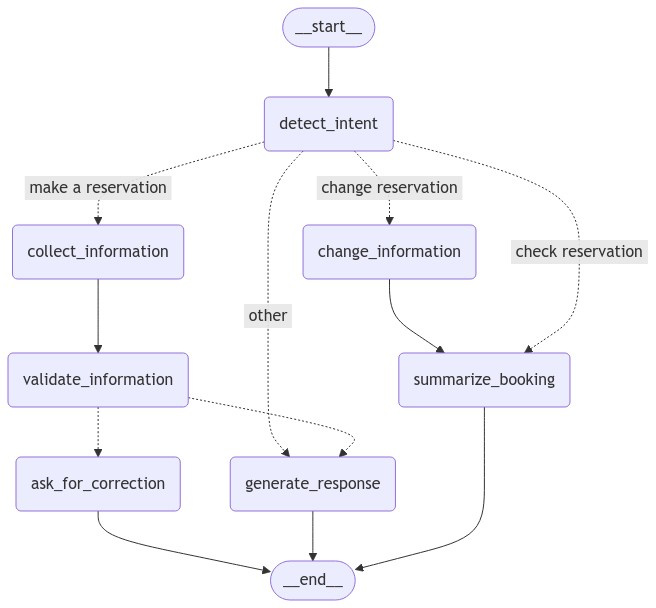

In [24]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

mermaid_png = app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
    # You can customize the appearance with additional parameters:
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
    wrap_label_n_words=9,
    background_color="white",
    padding=10,
)
display(Image(mermaid_png))

# Tests

In [13]:
# Test: Detect Intent for Making a Reservation
def test_detect_intent_make_reservation():
    state = {
        "user_message": "I want to book a room.",
        "not_filled_keys": NECESSARY_INFORMATION.copy(),
    }
    updated_state = run_graph(state)
    assert updated_state["intent"] == "make a reservation"
    print("\npass")
    
test_detect_intent_make_reservation()

Detecting intent from user's message...
Validating information...
Generating response...

pass


In [14]:
# Test: Collecting Information
def test_collect_information():
    state = {
        "user_message": "My name is John Doe, I need a room from 2024-10-20 to 2024-10-22.",
        "intent": "make a reservation",
        "not_filled_keys": NECESSARY_INFORMATION.copy(),
    }
    updated_state = run_graph(state)
    assert updated_state["full_name"] == "John Doe"
    assert updated_state["check_in_date"] == "2024-10-20"
    assert updated_state["check_out_date"] == "2024-10-22"
    assert "num_guests" in updated_state["not_filled_keys"]
    
    print("\npass")

test_collect_information()


Detecting intent from user's message...
Validating information...
Generating response...

pass


In [15]:
# Test: Validation of Information (Valid Case)
def test_validate_information_valid():
    state = {
        "user_message": "I want to book a room for 2 people, and I'll pay by credit card.",
        "intent": "make a reservation",
        "full_name": "John Doe",
        "check_in_date": "2024-10-20",
        "check_out_date": "2024-10-22",
        "num_guests": 2,
        "payment_method": "credit card",
        "breakfast_included": True,
        "valid_info": None,
        "error": [],
        "not_filled_keys": [],
    }
    updated_state = validate_information(state)
    assert updated_state["valid_info"] == True
    assert updated_state["error"] == []
    
    print("\npass")
    
test_validate_information_valid()


Validating information...

pass


In [16]:
# Test: Validation of Information (Invalid Case)
def test_validate_information_invalid():
    state = {
        "user_message": "I'll be checking in on 2023-10-20 and checking out on 2023-10-18, but only for 0 guests.",
        "intent": "make a reservation",
        "full_name": "John Doe",
        "check_in_date": "2023-10-20",
        "check_out_date": "2023-10-18",
        "num_guests": 0,
        "payment_method": "credit card",
        "breakfast_included": True,
        "valid_info": None,
        "error": [],
        "not_filled_keys": [],
    }
    updated_state = validate_information(state)
    assert updated_state["valid_info"] == False
    assert "Check-in date cannot be in the past." in updated_state["error"]
    assert "Check-out date must be after check-in date." in updated_state["error"]
    assert "Number of guests must be positive." in updated_state["error"]
    
    print("\npass")
    
test_validate_information_invalid()


Validating information...

pass


In [17]:
# Test: Generate Response
def test_generate_response():
    state = {
        "user_message": "I would like to book a room for 2 people from 2024-10-20 to 2024-10-22, with breakfast included.",
        "intent": "make a reservation",
        "full_name": "John Doe",
        "check_in_date": "2024-10-20",
        "check_out_date": "2024-10-22",
        "num_guests": 2,
        "payment_method": "credit card",
        "breakfast_included": True,
        "valid_info": True,
        "error": [],
        "not_filled_keys": [],
    }
    updated_state = generate_response(state)
    print(updated_state["response"])
    print("\npass")
    
test_generate_response()


Generating response...
Thank you, John, for providing the details for your reservation. Here is what I have:

- Check-in Date: 2024-10-20
- Check-out Date: 2024-10-22
- Number of Guests: 2
- Payment Method: Credit Card
- Breakfast Included: Yes

Would you like to proceed with this booking?

pass


In [18]:
# Test: Check Reservation Intent
def test_check_reservation():
    state = {
        "user_message": "Can you check my reservation?",
        "intent": None,
        "full_name": "John Doe",
        "check_in_date": "2024-10-20",
        "check_out_date": "2024-10-22",
        "num_guests": 2,
        "payment_method": "credit card",
        "breakfast_included": True,
        "valid_info": True,
        "error": [],
        "not_filled_keys": [],
    }
    updated_state = run_graph(state)
    print(updated_state["response"])
    assert updated_state["intent"] == "check reservation"
    
    print("\npass")
    
test_check_reservation()

Detecting intent from user's message...
Generating summary...
Hello John Doe!

Here's a summary of your current booking details:

- Check-in Date: October 20, 2024
- Check-out Date: October 22, 2024
- Number of Guests: 2
- Payment Method: Credit Card
- Breakfast Included: Yes

It looks like we have all the necessary information for your reservation. Your booking is confirmed!

If there's anything you'd like to change or if you have any questions, feel free to let me know. I'm here to help!

pass


In [27]:
# testing changing the reservation
def test_change_reservation():
    current_state = {
    "user_message": "On a second thought, I will not want breakfast. Besides, I prefer to pay with credit card. Change these",
    "intent": "make a reservation",
    "full_name": "Hugo Albuquerque Cosme da Silva",
    "check_in_date": "2024-10-23",
    "check_out_date": "2024-10-30",
    "num_guests": 3,
    "payment_method": "cash",
    "breakfast_included": True,
    "valid_info": True,
    "error": [],
    "not_filled_keys": [],
    "response": "Thank you, Hugo, for providing the details for your reservation. Here is a summary of your booking:\n\n- Check-in Date: 2024-10-23\n- Check-out Date: 2024-10-30\n- Number of Guests: 3\n- Payment Method: Cash\n- Breakfast Included: Yes\n\nWould you like to proceed with this booking?",
    }

    
    updated_state = run_graph(current_state)
    assert updated_state["breakfast_included"] == False
    assert updated_state["payment_method"] == "credit card"
    
    print("\n\n pass")
    
test_change_reservation()   

Detecting intent from user's message...
Changing booking information...
Generating summary...


 pass


# Simulating  conversations

In [28]:
from pprint import pprint

# Define the interactive loop
def interactive_conversation():
    
    message = (
        "Hi! I am GrandVista's hotel booking assistant. How may I assist you today? "
    )
    print(message)
    user_message = input(message)
    # Initial state with empty information
    state = {
        "user_message":user_message,
        "not_filled_keys": NECESSARY_INFORMATION.copy(),
    }

    state = run_graph(state)
    
    # Loop until the not_filled_keys list is empty
    while state["not_filled_keys"]:
        # print the assistant's response
        print("\n\n")
        print(state["response"])
        
        
        # get the user's next message
        state['user_message'] = input(state["response"])
        
        # Run the graph with the updated state
        state = run_graph(state)
        # print the current state for debugging
        print("\n\n")
        pprint(state)

    return state

# Run the interactive loop
final_state = interactive_conversation()


Hi! I am GrandVista's hotel booking assistant. How may I assist you today? 
Detecting intent from user's message...
Validating information...
Generating response...



Hello! I'd be happy to help you make a reservation. Could you please provide your full name to get started?
Detecting intent from user's message...
Validating information...
Generating response...



{'error': [],
 'full_name': 'Hugo Albuquerque Cosme da Silva',
 'intent': 'make a reservation',
 'not_filled_keys': ['check_in_date',
                     'check_out_date',
                     'payment_method',
                     'breakfast_included'],
 'num_guests': 3,
 'response': "Hi Hugo! Let's get your reservation set up. Could you please "
             'provide the check-in and check-out dates in the format '
             'YYYY-MM-DD?',
 'user_message': 'Hugo Albuquerque Cosme da Silva',
 'valid_info': True}



Hi Hugo! Let's get your reservation set up. Could you please provide the check-in and check-out dates in t

KeyboardInterrupt: 

In [ ]:
final_state

In [ ]:
# checking the 